In [1]:
%load_ext autoreload

%autoreload 2

import scenarion
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import copy

# Football - SKLearn example

# Table of Contents
1. [Description](#example_description)
1. [Generate the data](#data_generation)
1. [Do one-hot-encoding](#one_hot)
1. [Train the model](#train)
1. [Use Scenarion to interpret the model](#scenarion) (this is the only section that actually uses Scenarion)

# Description

* Regression task
* Model: sklearn.ExtraTreesRegressor
* Features: continous and categorical


The point here is to demonstrate how Scenarion can help demonstrate when a single feature has multiple, different relationships with the variable you'd like to predict (for different subsets of the data). This example also demonstrates how a model can give unrealistic results for out-of-sample scenarios and highlights the importance of recognizing those scenarios as out-of-sample.

# Generate the data <a name='data_generation'></a>
We'll predict athletic performance of NFL players. Our features will be what position they play and their weight.

In [2]:
# Create offensive tackle data
n_tackles = 5000
n_receivers = 4000

def tackle_performance(size, noise=50):
    x = np.linspace(-20, 10, size)
    return (500 -x**2 + np.random.randn(size)*noise)/700

weights = np.linspace(210, 400, n_tackles)
speeds = np.random.randn(len(weights))/10
performances = tackle_performance(len(weights)) + speeds

tackle_df = pd.DataFrame()
tackle_df['weight'] = weights
tackle_df['speed'] = speeds
tackle_df['performance'] = performances
tackle_df['position'] = 'offensive tackle'

# Create wide receiver data
def receiver_performance(size, noise=500):
    x = np.linspace(-10, 60, size)
    return 0.85+(-x**2 + np.random.randn(size)*noise)/5000

weights = np.linspace(165, 300, n_receivers)
speeds = np.random.randn(len(weights))/10
performances = receiver_performance(len(weights)) + speeds

receiver_df = pd.DataFrame()
receiver_df['weight'] = weights
receiver_df['speed'] = speeds
receiver_df['performance'] = performances
receiver_df['position'] = 'wide receiver'

df = pd.concat([tackle_df, receiver_df])


# view a sample of the DataFrame
df.sample(4)

,weight,speed,performance,position
3478,342.190438,0.166492,0.961875,offensive tackle
2260,241.294074,-0.089662,0.669241,wide receiver
3808,293.552138,-0.124263,0.070952,wide receiver
524,182.689422,0.145499,1.118869,wide receiver


## Do one hot encoding on categorical variables<a name='one_hot'></a>

In [3]:
new_df = copy.copy(df)

dummy_data = pd.get_dummies(df['position'])

new_df = pd.concat([new_df, dummy_data], axis=1)

# Train the model<a name='train'></a>

In [4]:
y_col = 'performance'
x_cols = ['weight','offensive tackle', 'wide receiver', 'speed']

train_x = new_df[x_cols]
train_y = new_df[y_col]

model = ExtraTreesRegressor(n_estimators=100, min_samples_leaf=100)
model.fit(train_x, train_y);

# Use Scenarion to interpret the model <a name='scenarion'></a>

### How does a players weight impact their performance?
(Interpreting the effects of a continuous variable)

Testing Scenarios: 100%|██████████| 100/100 [00:03<00:00, 28.29it/s]


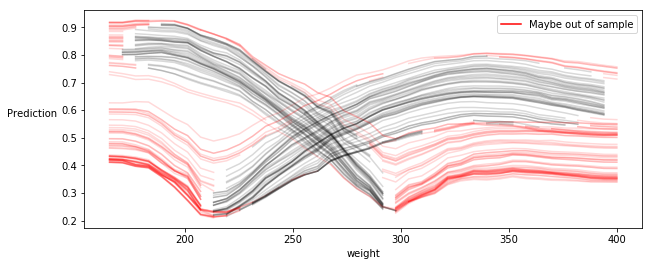

In [5]:
col_to_test = 'weight'
scenarios_df = scenarion.test_scenarios(model, new_df, x_cols, 
                                feat_to_test=col_to_test, n_samples=100,
                                hide_oos=False)

**Figure Interpretation:** For some football players, increasing weight tends to decrease performance, while for other's increasing weight (up to a point) tends to _increase_ performance. It turns out that this can easilyt be explained by a player's position (wide receivers should be lighter than offensive tackles). It is also clear from the figure that we shouldn't trust the model's out-of-sample predictions. Because the model wasn't trained on any 350 pound wide recievers, it didn't learn that that would reduce performance, and for the 350 pound player's that the model _was_ trained on (tackles) that wasn't problematic. As such, the out-of-sample scenarios (in red) give unintuitive (and almost certainly innacurate) results.

### Interpreting the effects of a categorical value

Testing Scenarios: 100%|██████████| 100/100 [00:03<00:00, 27.59it/s]


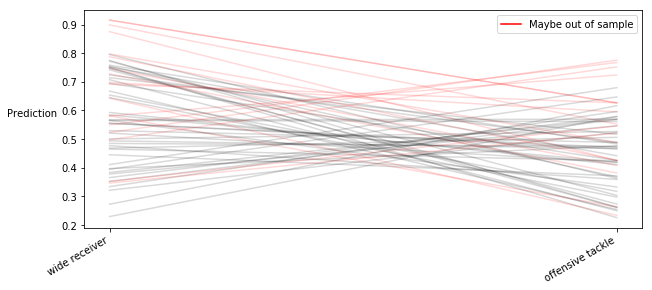

In [6]:
categorical_columns = ['wide receiver', 'offensive tackle']
scenarios_df = scenarion.test_scenarios(model, new_df, x_cols, 
                                categorical_columns, n_samples=100,
                                hide_oos=False)